# Healpy tutorial
Created by Zili Shen 03/21/2019

This notebook is an example to get you started with healpy. Healpy only does one thing: break areas on a spherical surface into equal-area pixels. It has many helper functions to convert from coordinate systems (e.g. RA and Dec) to pixel position and helps you plot things on sky.

In [8]:
# std lib
from collections import OrderedDict
from getpass import getpass
import warnings
from matplotlib.colors import LogNorm
warnings.filterwarnings('ignore') # to suppress some astropy deprecation warnings

# 3rd party
import numpy as np
import pylab as plt
from astropy import utils, io, convolution, wcs, stats
from astropy.visualization import make_lupton_rgb
from astropy.coordinates import name_resolve
from pyvo.dal import sia
import pandas as pd
from scipy.ndimage.filters import gaussian_filter
from photutils import find_peaks
from scipy.spatial import cKDTree
import healpy as hp

%matplotlib inline

# Data Lab
from dl import authClient as ac, queryClient as qc, storeClient as sc
from dl.helpers.utils import convert
from dl.helpers.crossmatch import xmatch

# set up Simple Image Access (SIA) service
DEF_ACCESS_URL = "http://datalab.noao.edu/sia/des_dr1"
svc = sia.SIAService(DEF_ACCESS_URL)

## Authentication
### Uploading
These cells are necessary for me to put this file into vospace, but you should not run them.

In [2]:
token = ac.login(input('Enter user name (+ENTER): '),getpass('Enter password (+ENTER): '))  

Enter user name (+ENTER): zilishen
Enter password (+ENTER): ········


In [24]:
!datalab put fr="./Healpy_tutorial.ipynb" to="vos://public/des/"

### Downloading
The following cell is for you to retrieve the latest version of the notebook.

In [ ]:
token = ac.login(input('Enter user name (+ENTER): '),getpass('Enter password (+ENTER): '))  
#Retrieving the latest notebook to your current directory
sc.get (fr = 'zilishen://public/des/Healpy_pixels.ipynb', to = './Healpy_pixels.ipynb')

## Reading in the data

In [2]:
df = pd.read_csv('des_dr1_g_i_small_box.csv')
print(df.shape)
df.head()

(305817, 9)


,ra,dec,mag_auto_g,mag_auto_i,spread_model_r,magerr_auto_g,spreaderr_model_r,magerr_auto_i,tilename
0,326.893500,-39.919220,23.179918,23.469385,-0.010718,0.231884,0.004499,0.644059,DES2148-3957
1,326.941361,-39.789704,17.020658,17.383627,0.000273,0.001475,0.000022,0.003444,DES2148-3957
2,327.339690,-40.030502,22.474710,22.546764,-0.005603,0.080204,0.002690,0.174881,DES2148-3957
3,327.196766,-39.860714,17.485518,17.717770,-0.000003,0.001582,0.000060,0.003320,DES2148-3957
4,327.519006,-40.082185,21.122114,21.316036,0.000358,0.018762,0.000623,0.046286,DES2148-3957


## How many pixels?
Healpy is defined in the following way:
1. As a minimum, you start with a sphere divided into 12 pixels
2. Each iteration can split one pixel into four new ones
3. Thus the number of pixels is not any integer, as illustrated in the following cell

In [3]:
# Healpix resolution parameters
n_exp = 5
nside = 2**n_exp #Drlica-Wagner 2015: nside = 4096
npix = 12 * 4**n_exp

print("n_exp =", n_exp, "n_side =", nside, "n_pix =", npix)

n_exp = 5 n_side = 32 n_pix = 12288


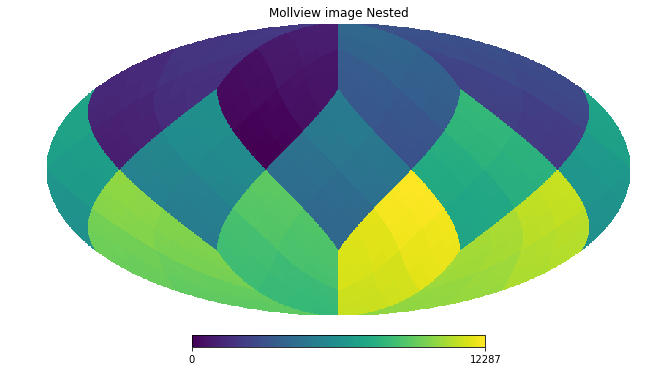

In [13]:
m = np.arange(hp.nside2npix(nside))
hp.mollview(m, title="Mollview image Nested",nest=True)
# Ring is the default way to order each pixel, labeling them top to bottom

# Using Healpy to calculate a pixelized density map
Now we can attack our data with healpy pixels and break it down!

In [5]:
import collections
# Calculate the area of one pixel (useful for density map)
area = hp.nside2pixarea(nside,degrees=True)
print(area)

# Read in the ra and dec coordinates for each star
lon,lat = df['ra'],df['dec']
pix = hp.ang2pix(nside,lon,lat,lonlat=True) # Convert to healpy pixel position

# Count how many stars in each pixel
counts = collections.Counter(pix)
pixels, number = np.array(sorted(counts.items())).T
density = number/area

3.357174580844667


In [6]:
print (np.median(number))

124.0


(array([126., 141., 673., 478., 199.,  43.,  10.,   7.,   2.,   5.,   3.,
          1.,   2.,   0.,   1.,   3.,   4.,   0.,   1.,   0.,   0.,   1.,
          0.,   0.,   1.,   0.,   0.,   0.,   1.,   1.,   0.,   1.,   0.,
          1.,   0.,   0.,   1.,   0.,   1.,   0.,   0.,   0.,   0.,   1.,
          1.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,
          0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0., 

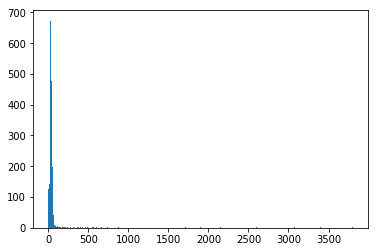

In [11]:
data = dict(PIXEL=pixels,DENSITY=density)
plt.hist(density,bins=300) #distribution of pixel density

## Final plot
As we said before, the number of pixels is not arbitrary. The healpy plotting tool (mollview) expects a pixel number that makes sense. But the way we calculated density, we only included the pixels that have some stars in it.
Thus I used our pixel index and density to fill in an array with the correct npix, and plot that.

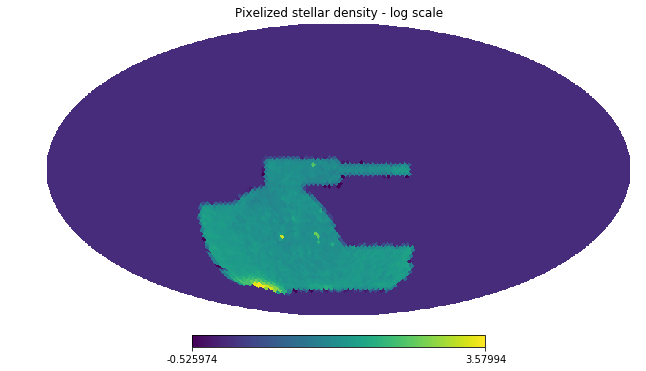

In [8]:
plotarray = np.zeros(npix)
for i in np.arange(len(pixels)):
        plotarray[pixels[i]] = np.log10(density[i])
        #plotarray[pixels[i]] = density[i]
hp.mollview(plotarray, title='Pixelized stellar density - log scale')

## Compare this to the DES footprint
It matches! 
![Just go Google DES footprint if link is broken](https://www.darkenergysurvey.org/wp-content/uploads/2015/04/DESObservingStrategy_Lahav2016-768x460.png "DES footprint")

# Appendix
I am including a couple other pieces of code that I found here and there (from the ugali package).
It may be helpful as a future reference, but will not run right now.

In [ ]:
def stellarDensity(infile, nside=256, lon_field='RA', lat_field='DEC'): 
    area = hp.nside2pixarea(nside,degrees=True)
    data = fitsio.read(infile,columns=[lon_field,lat_field])

    lon,lat = data[lon_field],data[lat_field]
    pix = ang2pix(nside,lon,lat)
    counts = collections.Counter(pix)
    pixels, number = np.array(sorted(counts.items())).T
    density = number/area

    return pixels, density

In [ ]:
def write_partial_map(filename, data, nside, coord=None, nest=False,
                      header=None,dtype=None,**kwargs):
    """
    Partial HEALPix maps are used to efficiently store maps of the sky by only
    writing out the pixels that contain data.

    Three-dimensional data can be saved by supplying a distance modulus array
    which is stored in a separate extension.

    Parameters:
    -----------
    filename : output file name
    data     : dictionary or recarray of data to write (must contain 'PIXEL')
    nside    : healpix nside of data
    coord    : 'G'alactic, 'C'elestial, 'E'cliptic
    ordering : 'RING' or 'NEST'
    kwargs   : Passed to fitsio.write

    Returns:
    --------
    None
    """
    # ADW: Do we want to make everything uppercase?

    if isinstance(data,dict):
        names = list(data.keys())
    else:
        names = data.dtype.names

    if 'PIXEL' not in names:
        msg = "'PIXEL' column not found."
        raise ValueError(msg)

    hdr = header_odict(nside=nside,coord=coord,nest=nest)
    fitshdr = fitsio.FITSHDR(list(hdr.values()))
    if header is not None:
        for k,v in header.items():
            fitshdr.add_record({'name':k,'value':v})

    logger.info("Writing %s"%filename)
    fitsio.write(filename,data,extname='PIX_DATA',header=fitshdr,clobber=True)

def read_partial_map(filenames, column, fullsky=True, **kwargs):
    """
    Read a partial HEALPix file(s) and return pixels and values/map. Can
    handle 3D healpix maps (pix, value, zdim). Returned array has
    shape (dimz,npix).

    Parameters:
        -----------
    filenames     : list of input filenames
    column        : column of interest
    fullsky       : partial or fullsky map
    kwargs        : passed to fitsio.read

    Returns:
    --------
    (nside,pix,map) : pixel array and healpix map (partial or fullsky)
    """
    # Make sure that PIXEL is in columns
    #kwargs['columns'] = ['PIXEL',column]
    kwargs['columns'] = ['PIXEL'] + np.atleast_1d(column).tolist()

    filenames = np.atleast_1d(filenames)
    header = fitsio.read_header(filenames[0],ext=kwargs.get('ext',1))
    data = ugali.utils.fileio.load_files(filenames,**kwargs)

    pix = data['PIXEL']
    value = data[column]
    nside = header['NSIDE']
    npix = hp.nside2npix(nside)

    ndupes = len(pix) - len(np.unique(pix))
    if ndupes > 0:
        msg = '%i duplicate pixels during load.'%(ndupes)
        raise Exception(msg)

    if fullsky and not np.isscalar(column):
        raise Exception("Cannot make fullsky map from list of columns.")

    if fullsky:
        shape = list(value.shape)
        shape[0] = npix
        hpxmap = hp.UNSEEN * np.ones(shape,dtype=value.dtype)
        hpxmap[pix] = value
        return (nside,pix,hpxmap.T)
    else:
        return (nside,pix,value.T)
